In [ ]:

#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

Obs: Todo esse notebook foi rodado no ambiente do Google Colab

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Preparando a base para treinamento


In [ ]:
import pandas as pd

df = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/df_xlabel', index_col=0)
df
X = df['description']
df['category_id'] = df['genre'].factorize()[0]
y = df['category_id']
category_id_df = df[['genre', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'genre']].values)
y.head(), category_id_df

(3     0
 5     1
 7     2
 10    2
 12    0
 Name: category_id, dtype: int64,          genre  category_id
 3   Historical            0
 5      Fantasy            1
 7      Mystery            2
 16     Romance            3)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test, indices_train, indices_test  = train_test_split(X, y, df.index, test_size=0.2, random_state = 56, stratify=y)

In [ ]:
y_train

28538    2
15998    1
18190    2
10158    1
16548    1
        ..
14495    3
52439    2
45634    2
4830     2
34056    3
Name: category_id, Length: 23314, dtype: int64

## RNN

In [ ]:
import tensorflow as tf

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np 

In [ ]:
y_train_one_hot = tf.one_hot(y_train, 4)

y_test_one_hot = tf.one_hot(y_test, 4)
y_train_one_hot, y_test_one_hot

(<tf.Tensor: shape=(23314, 4), dtype=float32, numpy=
 array([[0., 0., 1., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        ...,
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]], dtype=float32)>,
 <tf.Tensor: shape=(5829, 4), dtype=float32, numpy=
 array([[0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [0., 1., 0., 0.],
        ...,
        [1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [1., 0., 0., 0.]], dtype=float32)>)

label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(y_train)
y_train = label_tokenizer.texts_to_sequences(y_train)
y_train = [item[0] for item in y_train]
y_train = tf.one_hot(y_train, 4)

y_test = label_tokenizer.texts_to_sequences(y_test)
y_test = [item[0] for item in y_test]
y_test = tf.one_hot(y_test, 4)

In [ ]:
max_length = 200

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
vocab_size = len(tokenizer.word_index)+1

X_seq_train = tokenizer.texts_to_sequences(X_train)
X_pad_train = pad_sequences(X_seq_train, maxlen=max_length)

X_seq_test = tokenizer.texts_to_sequences(X_test)
X_pad_test = pad_sequences(X_seq_test, maxlen=max_length)

X_pad_train, vocab_size

(array([[ 1826,     6,    20, ...,     5,   931,   265],
        [    0,     0,     0, ...,   880,  5906,  6498],
        [    0,     0,     0, ...,     7, 19344, 30629],
        ...,
        [    0,     0,     0, ...,   225,   170,    51],
        [    0,     0,     0, ...,     1,   483,    41],
        [    0,     0,     0, ...,    19,  2593, 50800]], dtype=int32), 101611)

In [ ]:
from tqdm import tqdm

embedding_vector = {}
f = open('/content/gdrive/My Drive/Colab Notebooks/glove.6B.300d.txt')
for line in tqdm(f):
    value = line.split(' ')
    word = value[0]
    coef = np.array(value[1:],dtype = 'float32')
    embedding_vector[word] = coef

400000it [00:39, 10005.10it/s]


In [ ]:
embedding_matrix = np.zeros((vocab_size,300))
for word,i in tqdm(tokenizer.word_index.items()):
    embedding_value = embedding_vector.get(word)
    if embedding_value is not None:
        embedding_matrix[i] = embedding_value

100%|██████████| 101610/101610 [00:00<00:00, 488191.34it/s]


In [ ]:
  model = Sequential()
  model.add(Embedding(vocab_size,300,weights = [embedding_matrix],input_length=200,trainable = False))
  model.add(LSTM(50, return_sequences=True))
  model.add(Dropout(0.3))
  model.add(LSTM(30))
  model.add(Dense(4,activation = 'softmax'))
  adam = Adam(lr=0.005)
  model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
  model.summary()
  history = model.fit(X_pad_train, y_train_one_hot, epochs=5, verbose=1, validation_data=(X_pad_test, y_test_one_hot))


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 300)          30483300  
_________________________________________________________________
lstm (LSTM)                  (None, 200, 50)           70200     
_________________________________________________________________
dropout (Dropout)            (None, 200, 50)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 30)                9720      
_________________________________________________________________
dense (Dense)                (None, 4)                 124       
Total params: 30,563,344
Trainable params: 80,044
Non-trainable params: 30,483,300
_________________________________________________________________
Epoch 1/5
729/729 [==============================] - 20s 27ms/step - loss: 0.8360 - accuracy: 0.6791 - va

In [ ]:
y_pred = model.predict_classes(X_pad_test)
df_test = pd.DataFrame(zip(X_test, [id_to_category[i] for i in y_test], [id_to_category[i] for i in y_pred]), index = indices_test, columns=['description', 'genre', 'pred_genre'])
df_test.to_csv('df_test.csv')

In [ ]:
  model2 = Sequential()
  model2.add(Embedding(vocab_size,300,weights = [embedding_matrix],input_length=X_pad_train.shape[1],trainable = False))
  model2.add(LSTM(100, return_sequences=True))
  model2.add(Dropout(0.5))
  model2.add(LSTM(20))
  model2.add(Dense(4,activation = 'softmax'))
  adam2 = Adam(lr=0.005)
  model2.compile(loss='categorical_crossentropy', optimizer=adam2, metrics=['accuracy'])
  model2.summary()
  history2 = model.fit(X_pad_train, y_train_one_hot, epochs=5, verbose=1, validation_data=(X_pad_test, y_test_one_hot))


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 750, 300)          30483300  
_________________________________________________________________
lstm_2 (LSTM)                (None, 750, 100)          160400    
_________________________________________________________________
dropout_1 (Dropout)          (None, 750, 100)          0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 20)                9680      
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 84        
Total params: 30,653,464
Trainable params: 170,164
Non-trainable params: 30,483,300
_________________________________________________________________
Epoch 1/5
729/729 [==============================] - 45s 61ms/step - loss: 0.4365 - accuracy: 0.8407 -

In [ ]:
  model2 = Sequential()
  model2.add(Embedding(vocab_size,300,weights = [embedding_matrix],input_length=X_pad_train.shape[1],trainable = False))
  model2.add(LSTM(100))
  model2.add(Dense(4,activation = 'softmax'))
  adam2 = Adam(lr=0.005)
  model2.compile(loss='categorical_crossentropy', optimizer=adam2, metrics=['accuracy'])
  model2.summary()
  history2 = model.fit(X_pad_train, y_train_one_hot, epochs=5, verbose=1, validation_data=(X_pad_test, y_test_one_hot))

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 750, 300)          30483300  
_________________________________________________________________
lstm_4 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 404       
Total params: 30,644,104
Trainable params: 160,804
Non-trainable params: 30,483,300
_________________________________________________________________
Epoch 1/5
729/729 [==============================] - 45s 62ms/step - loss: 0.2523 - accuracy: 0.9127 - val_loss: 0.7146 - val_accuracy: 0.7787
Epoch 2/5
729/729 [==============================] - 44s 61ms/step - loss: 0.2351 - accuracy: 0.9190 - val_loss: 0.7780 - val_accuracy: 0.7710
Epoch 3/5
729/729 [==============================] - 44s 60ms/step - loss: 0.215

In [ ]:
model.predict_classes(X_pad_test)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


array([3, 3, 1, ..., 0, 0, 0])

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred_rnn = model.predict_classes(X_pad_test)

conf_mat_rnn = confusion_matrix(y_test, y_pred_rnn)
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(conf_mat_rnn, annot=True, fmt='d',
            xticklabels=category_id_df.genre.values, yticklabels=category_id_df.genre.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

NameError: ignored

In [ ]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.show()

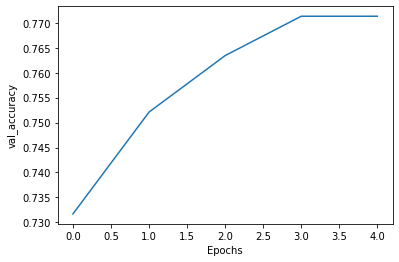

In [ ]:
plot_graphs(history, 'val_accuracy')


## Outros classificadores

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=10, norm='l2', ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(X_train).toarray()
labels = y_train
features.shape

(23314, 22441)

In [ ]:
from sklearn.feature_selection import chi2
import numpy as np
N = 10
for genre, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("# '{}':".format(genre))
  print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

# 'Fantasy':
  . Most correlated unigrams:
. planet
. creatures
. powers
. kingdom
. evil
. dragon
. earth
. fantasy
. magical
. magic
  . Most correlated bigrams:
. human race
. good evil
. war ii
. save world
. harry potter
. fairy tales
. world war
. epic fantasy
. fantasy series
. science fiction
# 'Historical':
  . Most correlated unigrams:
. hitler
. jewish
. german
. england
. novel
. century
. american
. ii
. war
. historical
  . Most correlated bigrams:
. richard sharpe
. pulitzer prize
. henry viii
. second world
. twentieth century
. civil war
. historical novel
. historical fiction
. war ii
. world war
# 'Mystery':
  . Most correlated unigrams:
. holmes
. mystery
. investigation
. thriller
. police
. crime
. case
. killer
. detective
. murder
  . Most correlated bigrams:
. stephanie plum
. lieutenant eve
. agatha christie
. scotland yard
. hercule poirot
. mrs jeffries
. mystery series
. serial killer
. eve dallas
. sherlock holmes
# 'Romance':
  . Most correlated unigrams:

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
X_test_counts = count_vect.transform(X_test)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_test_tfidf = tfidf_transformer.transform(X_test_counts)


0.7922456682106708


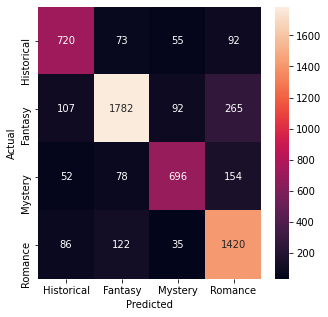

In [ ]:
clf = MultinomialNB(alpha=0.1, fit_prior=False)
clf.fit(X_train_tfidf, y_train)
y_pred_nb = clf.predict(X_test_tfidf)
print(clf.score(X_test_tfidf, y_test))

conf_mat_nb = confusion_matrix(y_test, y_pred_nb)
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(conf_mat_nb, annot=True, fmt='d',
            xticklabels=category_id_df.genre.values, yticklabels=category_id_df.genre.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import GridSearchCV

0.8148910619317207


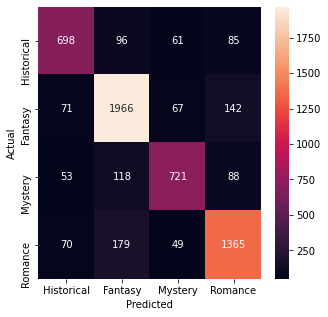

In [ ]:
svc = LinearSVC(penalty='l2', loss='squared_hinge', dual=True)
svc.fit(X_train_tfidf, y_train)
y_pred_svc = svc.predict(X_test_tfidf)
print(svc.score(X_test_tfidf, y_test))

conf_mat_svc = confusion_matrix(y_test, y_pred_svc)
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(conf_mat_svc, annot=True, fmt='d',
            xticklabels=category_id_df.genre.values, yticklabels=category_id_df.genre.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
for predicted in category_id_df.category_id:
  for actual in category_id_df.category_id:
    if predicted != actual and conf_mat[actual, predicted] >= 10:
      print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], id_to_category[predicted], conf_mat[actual, predicted]))
      display(df.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['genre', 'description']])
      print('')

NameError: ignored

0.8006519128495454


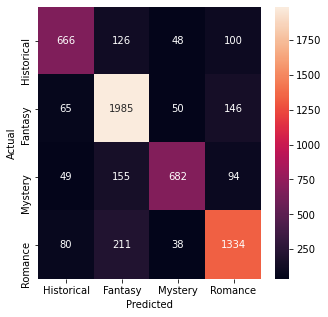

In [ ]:
lr = LogisticRegression(random_state=43, max_iter=200)

lr.fit(X_train_tfidf, y_train)
y_pred_lr = lr.predict(X_test_tfidf)
print(lr.score(X_test_tfidf, y_test))

conf_mat_lr = confusion_matrix(y_test, y_pred_lr)
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(conf_mat_lr, annot=True, fmt='d',
            xticklabels=category_id_df.genre.values, yticklabels=category_id_df.genre.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

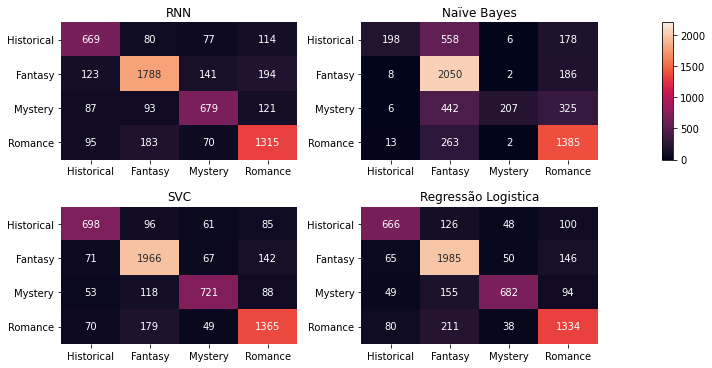

In [ ]:
vmin=0
vmax=2200

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(10,5), gridspec_kw=dict(width_ratios=[4,4,0.2]))
sns.heatmap(conf_mat_rnn, annot=True, fmt='d',
            xticklabels=category_id_df.genre.values, yticklabels=category_id_df.genre.values, ax=ax[0,0], cbar=False, vmin=vmin, vmax=vmax)
sns.heatmap(conf_mat_nb, annot=True, fmt='d',
            xticklabels=category_id_df.genre.values, yticklabels=category_id_df.genre.values, ax=ax[0,1], cbar=False, vmin=vmin, vmax=vmax)
sns.heatmap(conf_mat_svc, annot=True, fmt='d',
            xticklabels=category_id_df.genre.values, yticklabels=category_id_df.genre.values, ax=ax[1,0], cbar=False, vmin=vmin, vmax=vmax)
sns.heatmap(conf_mat_lr, annot=True, fmt='d',
            xticklabels=category_id_df.genre.values, yticklabels=category_id_df.genre.values, ax=ax[1,1], cbar=False, vmin=vmin, vmax=vmax)
fig.colorbar(ax[1,0].collections[0], cax=ax[0,2])
ax[1,2].axis('off')
fig.tight_layout(h_pad=3, w_pad=1)

ax[0,0].set_title('RNN')
ax[0,1].set_title('Naïve Bayes')
ax[1,0].set_title('SVC')
ax[1,1].set_title('Regressão Logistica')
plt.ylabel('Actual')
plt.xlabel('Predicted')
#plt.show()
plt.savefig('confusion_matrix.png', format='png', bbox_inches='tight')